In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, DepthwiseConv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense

# Define your class names
classes = ['Abnormal heartbeat',
           'History of MI',
           'MI Patients',
           'Normal']

# Initialize ImageDataGenerator for training and testing data with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load and augment data from the directory
train_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/preprocessed_ECG_images",
    target_size=(224, 224),  # MobileNetV2 input size
    batch_size=32,
    classes=classes,
    class_mode="categorical",
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/preprocessed_ECG_images",
    target_size=(224, 224),
    batch_size=32,
    classes=classes,
    class_mode="categorical",
    subset='validation'
)

# Get the number of classes
num_classes = len(classes)

class_weights = {}
total_samples = len(train_generator.classes)
for i in range(num_classes):
    if np.sum(train_generator.classes == i) != 0:
        class_weight = total_samples / (num_classes * np.sum(train_generator.classes == i))
    else:
        class_weight = 0  # Or any other default value
    class_weights[i] = class_weight


# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the MobileNetV2 base model
model.add(base_model)

# Add custom layers on top
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(DepthwiseConv2D((3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (1, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Define callbacks
checkpoint_path = "/content/drive/MyDrive/best_mobilenet_model1.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, reduce_lr, early_stop],
    class_weight=class_weights
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Found 745 images belonging to 4 classes.
Found 183 images belonging to 4 classes.
9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          737344    
                                                                 
 batch_normalization (Batch  (None, 7, 7, 64)          256       
 Normalization)                                                  
                                                                 
 activation_16 (Activation)  (None, 7, 7, 64)          0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 7, 7,

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 72s 3s/step - loss: 1.2590 - accuracy: 0.4336 - val_loss: 1.1569 - val_accuracy: 0.5683 - lr: 0.0010
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.9417 - accuracy: 0.6121
Epoch 2: val_accuracy improved from 0.56831 to 0.69945, saving model to /content/drive/MyDrive/best_mobilenet_model1.h5
24/24 [==============================] - 68s 3s/step - loss: 0.9417 - accuracy: 0.6121 - val_loss: 1.0728 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.7825 - accuracy: 0.6993
Epoch 3: val_accuracy improved from 0.69945 to 0.77049, saving model to /content/drive/MyDrive/best_mobilenet_model1.h5
24/24 [==============================] - 76s 3s/step - loss: 0.7825 - accuracy: 0.6993 - val_loss: 1.0081 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 4/50
24/24 [==============================] - ETA: 0s - loss: 0.7287 - accuracy: 0.7114
Epoch 4: val_accuracy did not improve from 0.77049
2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# Define your class names
classes = ['Abnormal heartbeat',
           'History of MI',
           'MI Patients',
           'Normal']

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


datagen_mi_history = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load all data from the directory
train_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/preprocessed_ECG_images",
    target_size=(64, 64),
    batch_size=32,
    classes=classes,
    class_mode="categorical",
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/preprocessed_ECG_images",
    target_size=(64, 64),
    batch_size=32,
    classes=classes,
    class_mode="categorical",
    subset='validation'
)

# Get the number of classes
num_classes = len(classes)


# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Define callbacks
checkpoint_path = "/content/drive/MyDrive/best_cnn_model1.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, reduce_lr, early_stop],

)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Found 745 images belonging to 4 classes.
Found 183 images belonging to 4 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 activation_12 (Activation)  (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 activation_13 (Activation)  (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load models
cnn_model = load_model('/content/drive/MyDrive/best_cnn_model1.h5')
mobilenet_model = load_model('/content/drive/MyDrive/best_mobilenet_model1.h5')

# Normalization only for evaluation
datagen = ImageDataGenerator(rescale=1./255)
cnn_test_generator = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/preprocessed_ECG_images/",  # Update with your path
    target_size=(64, 64),  # CNN model expects (64, 64)
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
mobilenet_test_generator = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/preprocessed_ECG_images/",  # Update with your path
    target_size=(224, 224),  # CNN model expects (64, 64)
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 928 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


29/29 [==============================] - 14s 462ms/step


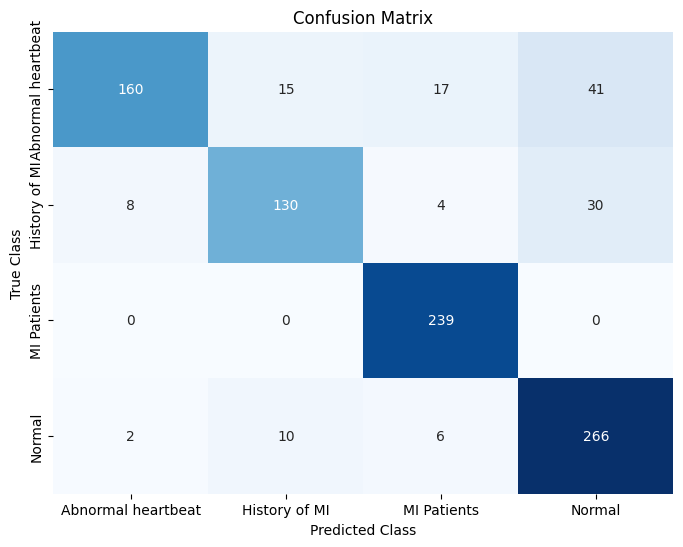

Classification Report:
                    precision    recall  f1-score   support

Abnormal heartbeat       0.94      0.69      0.79       233
     History of MI       0.84      0.76      0.80       172
       MI Patients       0.90      1.00      0.95       239
            Normal       0.79      0.94      0.86       284

          accuracy                           0.86       928
         macro avg       0.87      0.84      0.85       928
      weighted avg       0.86      0.86      0.85       928

Sensitivities: [0.6866952789699571, 0.7558139534883721, 1.0, 0.9366197183098591]
Specificities: [0.9856115107913669, 0.966931216931217, 0.9608127721335269, 0.889751552795031]


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_generator, steps):
    y_pred_prob = model.predict(test_generator, steps=steps)
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert predicted probabilities to class labels
    y_true = test_generator.classes

    # Calculate classification report
    report = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()))

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()


    # Calculate sensitivity and specificity for each class
    sensitivities = []
    specificities = []
    for i in range(len(cm)):
        tp = cm[i, i]  # True positive for class i
        fn = sum(cm[i, :]) - tp  # False negative for class i
        tn = sum(np.delete(np.delete(cm, i, 0), i, 1).ravel())  # True negative for class i
        fp = sum(cm[:, i]) - tp  # False positive for class i

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        sensitivities.append(sensitivity)
        specificities.append(specificity)

    return report, sensitivities, specificities

# Evaluate the model and plot the confusion matrix
cnn_steps = cnn_test_generator.samples // cnn_test_generator.batch_size
cnn_report, cnn_sensitivities, cnn_specificities = evaluate_model(cnn_model, cnn_test_generator, cnn_steps)

print(f"Classification Report:\n{cnn_report}")
print(f"Sensitivities: {cnn_sensitivities}")
print(f"Specificities: {cnn_specificities}")


29/29 [==============================] - 70s 2s/step


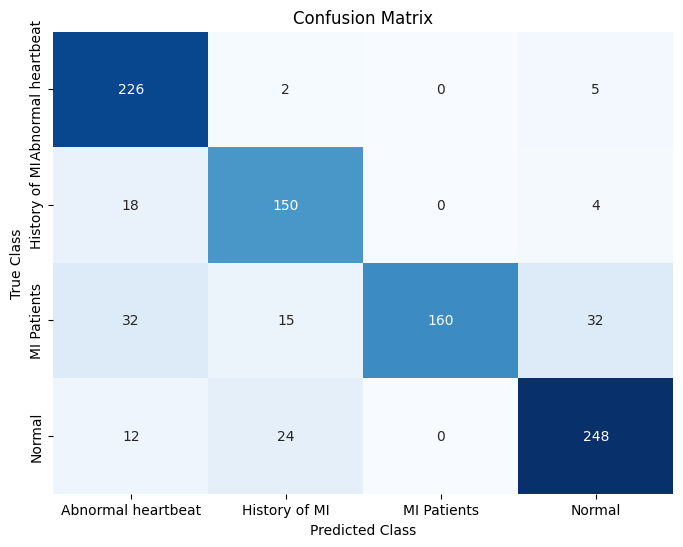

Classification Report:
                    precision    recall  f1-score   support

Abnormal heartbeat       0.78      0.97      0.87       233
     History of MI       0.79      0.87      0.83       172
       MI Patients       1.00      0.67      0.80       239
            Normal       0.86      0.87      0.87       284

          accuracy                           0.84       928
         macro avg       0.86      0.85      0.84       928
      weighted avg       0.86      0.84      0.84       928

Sensitivities: [0.9699570815450643, 0.872093023255814, 0.6694560669456067, 0.8732394366197183]
Specificities: [0.9107913669064748, 0.9457671957671958, 1.0, 0.9363354037267081]


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_generator, steps):
    y_pred_prob = model.predict(test_generator, steps=steps)
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert predicted probabilities to class labels
    y_true = test_generator.classes

    # Calculate classification report
    report = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()))

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()


    # Calculate sensitivity and specificity for each class
    sensitivities = []
    specificities = []
    for i in range(len(cm)):
        tp = cm[i, i]  # True positive for class i
        fn = sum(cm[i, :]) - tp  # False negative for class i
        tn = sum(np.delete(np.delete(cm, i, 0), i, 1).ravel())  # True negative for class i
        fp = sum(cm[:, i]) - tp  # False positive for class i

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        sensitivities.append(sensitivity)
        specificities.append(specificity)

    return report, sensitivities, specificities

# Evaluate the model and plot the confusion matrix
mobilenet_steps = mobilenet_test_generator.samples // mobilenet_test_generator.batch_size
mobilenet_report, mobilenet_sensitivities, mobilenet_specificities = evaluate_model(mobilenet_model, mobilenet_test_generator, mobilenet_steps)

print(f"Classification Report:\n{mobilenet_report}")
print(f"Sensitivities: {mobilenet_sensitivities}")
print(f"Specificities: {mobilenet_specificities}")
